In [140]:
'''
Library Settle
'''

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import os

import gc

from tqdm import tqdm

print(f'Import done')

Import done


In [2]:
%%time
'''
Setting datasets
'''

train_data = datasets.MNIST(root = './data/train/', train=True, download=False, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data/test/', train=False, download=False, transform = transforms.ToTensor())

print(f'Trian data : {len(train_data)}')
print(f'Test data : {len(test_data)}')


Trian data : 60000
Test data : 10000
Wall time: 145 ms


In [3]:
'''
EDA on the data
'''

print(f'Train/Test data contains {len(train_data[0])} information.\n')
print(f'First information is {train_data[0][0].size()}.')
print(f'Second information is label, for example {train_data[0][1]}.')

Train/Test data contains 2 information.

First information is torch.Size([1, 28, 28]).
Second information is label, for example 5.


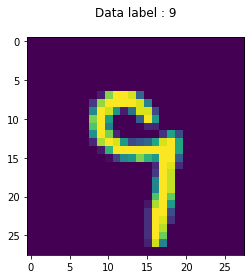

In [4]:
'''
EDA on the train/test data
'''

image, label = train_data[np.random.randint(low= 0, high = len(train_data))]

# squeeze() : Returns a tensor with all the dimensions of input of size 1 removed.
plt.imshow(image.squeeze().numpy())
plt.title(f'Data label : {label}\n')
plt.show()

In [43]:
'''
check the train data class
'''
train_class = dict()

for i in tqdm(range(len(train_data))):
    temp_class = train_data[i][1]

    if temp_class not in train_class:
        train_class[temp_class] = 1
    else:
        train_class[temp_class] += 1

print(f'Done')

100%|██████████| 60000/60000 [00:05<00:00, 10598.61it/s]

Done


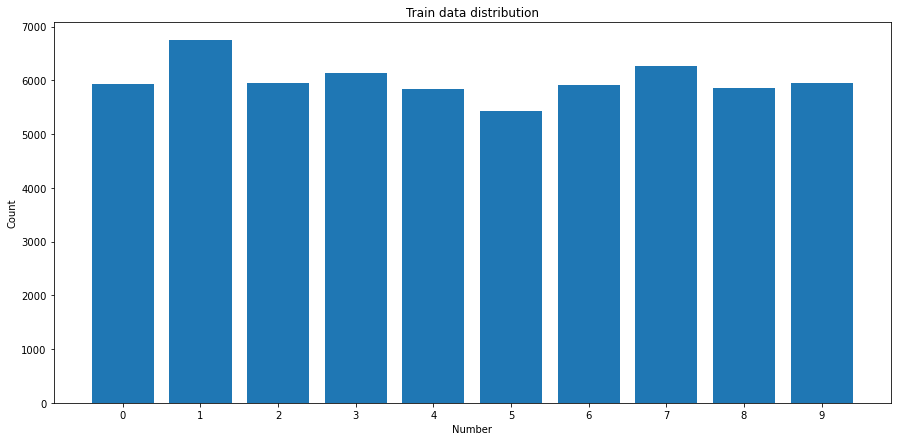

In [65]:
'''
Train data classification
'''

names, counts = zip(*train_class.items())

plt.figure(figsize = (15, 7))
plt.bar(names, counts, tick_label = names)
plt.title('Train data distribution')
plt.xlabel('Number')
plt.ylabel('Count')
plt.show()

In [66]:
'''
check the Test data class
'''
test_class = dict()

for i in tqdm(range(len(test_data))):
    temp_class = test_data[i][1]

    if temp_class not in test_class:
        test_class[temp_class] = 1
    else:
        test_class[temp_class] += 1

print(f'Done')

100%|██████████| 10000/10000 [00:00<00:00, 10744.52it/s]

Done


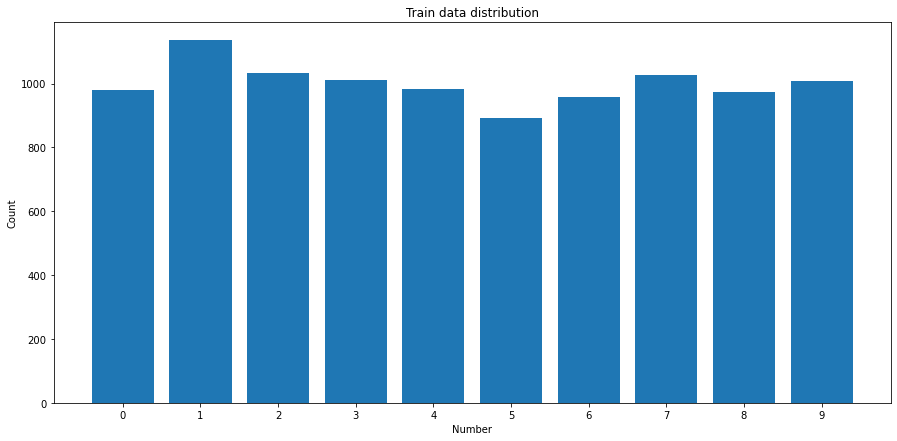

In [67]:
'''
Test data classification
'''

names, counts = zip(*test_class.items())

plt.figure(figsize = (15, 7))
plt.bar(names, counts, tick_label = names)
plt.title('Train data distribution')
plt.xlabel('Number')
plt.ylabel('Count')
plt.show()

In [141]:
'''
Set data loader

# need to apply stratification
'''
batch_count = 50

train_loader = torch.utils.data.DataLoader(dataset= train_data, batch_size=batch_count, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset= test_data, batch_size=batch_count, shuffle=True)

print(f'Load done.')

Load done.


In [146]:
class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=5,
            kernel_size=16, stride=1, padding=0
        )
        self.conv2 = nn.Conv2d(
            in_channels=5, out_channels=50,
            kernel_size=9, stride=1, padding=0
            )
        self.full1 = nn.Linear(50*5*5, 100)
        self.full2 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 50 * 5 * 5)
        x = F.relu(self.full1(x))
        x = self.full2(x)
        return x

cnn = cnn_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.005, momentum=0.9)


In [147]:
for epoch in tqdm(range(10)):
    running_loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1200 == 1199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

 10%|█         | 1/10 [00:13<01:59, 13.26s/it]

[1,  1200] loss: 0.214


 20%|██        | 2/10 [00:28<01:49, 13.75s/it]

[2,  1200] loss: 0.084


 30%|███       | 3/10 [00:42<01:37, 13.97s/it]

[3,  1200] loss: 0.066


 40%|████      | 4/10 [00:57<01:26, 14.34s/it]

[4,  1200] loss: 0.057


 50%|█████     | 5/10 [01:10<01:09, 13.97s/it]

[5,  1200] loss: 0.051


 60%|██████    | 6/10 [01:23<00:54, 13.56s/it]

[6,  1200] loss: 0.046


 70%|███████   | 7/10 [01:36<00:39, 13.27s/it]

[7,  1200] loss: 0.042


 80%|████████  | 8/10 [01:48<00:26, 13.14s/it]

[8,  1200] loss: 0.039


 90%|█████████ | 9/10 [02:01<00:13, 13.00s/it]

[9,  1200] loss: 0.037


100%|██████████| 10/10 [02:15<00:00, 13.55s/it]

[10,  1200] loss: 0.036


In [148]:
# erase memory

gc.collect()

72

In [149]:
'''
Model Evaluation
'''

cnn.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = cnn(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Average loss: 17.6871, Accuracy: 9722/10000 (97%)



In [150]:
print(f'DONE')

DONE
